# Homework 8
**Name:** Priyam Mazumdar

**NetID:** priyamm2

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quadprog
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

In [56]:
data = pd.read_csv("SVM-Q1.csv")
data.head()

,x1,x2,y
0,-0.961933,0.900625,1
1,-0.292526,0.851770,1
2,0.258788,0.727715,1
3,-1.152132,0.736502,1
4,0.195783,-0.352130,1


### Problem 1: Primal

Optimized Parameters:
b0: 3.419238439968422, b1: -1.045730602279066, b2: -0.9990793789686981


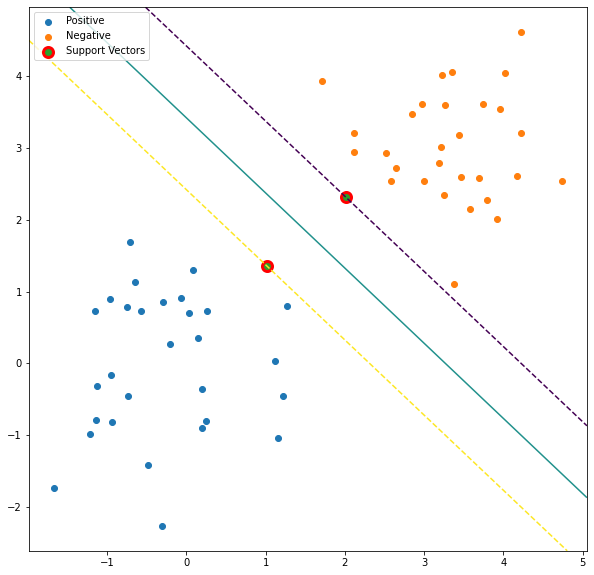

In [58]:
class Primal:
    def __init__(self, data):
        self.data = data
        self.x_y_product()
        self.r, self.c = self.new_data.shape
        self.D = np.eye(self.c) 
        self.D[0,0] = 1e-10
        self.A = np.matrix(self.new_data.T)
        self.d = np.zeros(self.c)
        self.int = np.ones(self.r)

    def x_y_product(self):
        new_data = pd.DataFrame()
        new_data["y"] = self.data["y"]
        new_data['x1_prod_y'] = self.data["x1"] * self.data["y"]
        new_data['x2_prod_y'] = self.data["x2"] * self.data["y"]
        self.new_data = new_data.values
        
    def solve_quad(self):
        b = quadprog.solve_qp(self.D, self.d, self.A, self.int)[0]
        return b
    
    def get_param_function(self):
        b = self.solve_quad()
        return (b, lambda x: b[0] + b[1]*x[0] + b[2]*x[1])
        
    
        
primal = Primal(data)
b, decision_function = primal.get_param_function()
b_primal = b.copy()
print("Optimized Parameters:")
print("b0: {}, b1: {}, b2: {}".format(*b))

### Plot SVM Output
decision_out = data[["x1", "x2"]].apply(decision_function, axis=1).values
float_tol = 1e-1
support_vec_idx = np.where(np.abs(decision_out) <= 1 + float_tol)
support_vec = data.iloc[support_vec_idx][["x1", "x2"]].values

plt.figure(figsize=(10,10))
plt.scatter(x='x1',y='x2',data=data.loc[data['y']==1],label='Positive')
plt.scatter(x='x1',y='x2',data=data.loc[data['y']==-1],label='Negative')


xlim = plt.xlim()
ylim = plt.ylim()

# create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
y = np.linspace(ylim[0], ylim[1], 30)
Y, X = np.meshgrid(y, x)
XY = np.vstack([X.flatten(), Y.flatten()])
P = decision_function(XY).reshape(X.shape)

plt.contour(X, Y, P, levels=[-1,0,1],linestyles=['--','-','--'])

plt.scatter(support_vec[:, 0], support_vec[:, 1], s=100, linewidth=3,edgecolors='r', label="Support Vectors")
plt.legend()
plt.show()

### Problem 1: Dual

Optimized Parameters:
b0: 3.347557970625637, b1: -1.045699880690632, b2: -0.9990666303413688


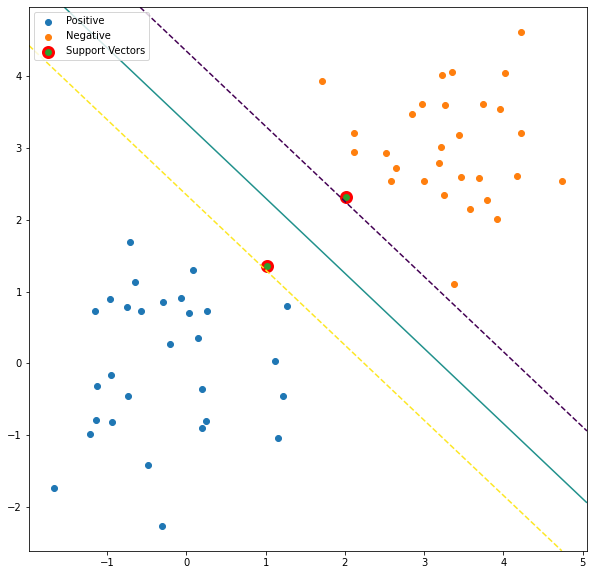

In [60]:
class Dual:
    def __init__(self, data):
        self.data = data
        self.x_y_product()
        self.r, self.c = self.new_data.shape
        self.D = (self.new_data[:, 1:] @ self.new_data[: , 1:].T) + 1e-10 * np.eye(self.r)
        self.A = np.hstack([self.new_data[:, 0].reshape(-1,1), np.diag(np.ones(self.r))]) + 1e-10
        self.d = np.ones(self.r)
        self.int = np.zeros(self.r + 1)
        
        
    def x_y_product(self):
        new_data = pd.DataFrame()
        new_data["y"] = self.data["y"]
        new_data['x1_prod_y'] = self.data["x1"] * self.data["y"]
        new_data['x2_prod_y'] = self.data["x2"] * self.data["y"]
        self.new_data = new_data.values
        
    def solve_quad(self):
        solve = quadprog.solve_qp(self.D,self.d,self.A,self.int,meq=1)[0]
        return solve
    
    def get_param_function(self):
        solve = self.solve_quad().reshape(-1,1)
        y = self.new_data[:, 0].reshape(-1, 1)
        orig_data = self.data.values[:,:2]
        
        # Calculate Coeff
        b = np.multiply((np.multiply(solve,y)), orig_data).sum(axis=0)
        
        # Calculate Intercept
        data_true = data.loc[data.loc[:, "y"] == 1].values[:, :2]
        data_false = data.loc[data.loc[:, "y"] == -1].values[:, :2]
        
        intercept = -1/2 * ((b @ data_false.reshape(2, -1)).max() +
                            (b @ data_true.reshape(2, -1))).min() 
        b = [intercept] + list(b)
        
        return (b, lambda x: b[0] + b[1]*x[0] + b[2]*x[1])
        
    
        
primal = Dual(data)
b, decision_function = primal.get_param_function()
b_dual = b.copy()
print("Optimized Parameters:")
print("b0: {}, b1: {}, b2: {}".format(*b))

### Plot SVM Output
decision_out = data[["x1", "x2"]].apply(decision_function, axis=1).values
float_tol = 1e-1
support_vec_idx = np.where(np.abs(decision_out) <= 1 + float_tol)
support_vec = data.iloc[support_vec_idx][["x1", "x2"]].values

plt.figure(figsize=(10,10))
plt.scatter(x='x1',y='x2',data=data.loc[data['y']==1],label='Positive')
plt.scatter(x='x1',y='x2',data=data.loc[data['y']==-1],label='Negative')


xlim = plt.xlim()
ylim = plt.ylim()

# create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
y = np.linspace(ylim[0], ylim[1], 30)
Y, X = np.meshgrid(y, x)
XY = np.vstack([X.flatten(), Y.flatten()])
P = decision_function(XY).reshape(X.shape)

plt.contour(X, Y, P, levels=[-1,0,1],linestyles=['--','-','--'])

plt.scatter(support_vec[:, 0], support_vec[:, 1], s=100, linewidth=3,edgecolors='r', label="Support Vectors")
plt.legend()
plt.show()



In [61]:
coeff_dict = {"primal": b_primal,
             "dual": b_dual}
summary_out = pd.DataFrame(coeff_dict)
summary_out.index = ["Intercept", "B1", "B2"]

display(summary_out.round(3))

l1_norm = np.abs(b_primal - b_dual).sum()
print("L1 Norm: {}".format(l1_norm))

,primal,dual
Intercept,3.419,3.348
B1,-1.046,-1.046
B2,-0.999,-0.999


L1 Norm: 0.07172393955854872


### Problem 2: Non-Separable SVM

In [62]:
data = pd.read_csv("SVM-Q2.csv")

Optimized Parameters:
b0: -1.732839149322823, b1: 1.1516472993871645, b2: 1.110986116802259


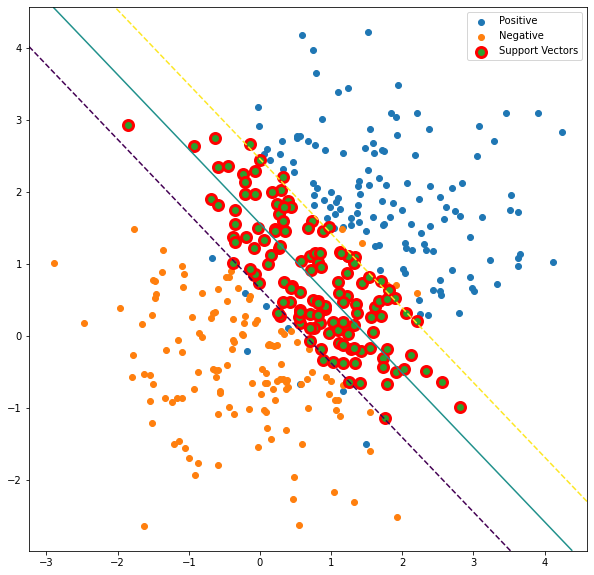

Misclassification Error: 0.147


In [63]:
class NonSeparable:
    def __init__(self, data):
        self.data = data
        self.x_y_product()
        self.r, self.c = self.new_data.shape
        self.D = (self.new_data[:, 1:] @ self.new_data[: , 1:].T) + 1e-10 * np.eye(self.r)
        self.A = np.hstack([self.new_data[:, 0].reshape(-1,1), 
                            np.diag(np.ones(self.r)), 
                           -np.diag(np.ones(self.r))])
        self.d = np.ones(self.r)
        self.int = np.concatenate([np.zeros(self.r + 1), -np.ones(self.r)])
        
    def x_y_product(self):
        new_data = pd.DataFrame()
        new_data["y"] = self.data["y"]
        new_data['x1_prod_y'] = self.data["x1"] * self.data["y"]
        new_data['x2_prod_y'] = self.data["x2"] * self.data["y"]
        self.new_data = new_data.values
        
    def solve_quad(self):
        solve = quadprog.solve_qp(self.D,self.d,self.A,self.int,meq=1)[0]
        solve = np.clip(solve, 0, 1)
        return solve
    
    def get_param_function(self):
        solve = self.solve_quad().reshape(-1,1)
        y = self.new_data[:, 0].reshape(-1, 1)
        orig_data = self.data.values[:,:2]
        
        # Calculate Coeff
        b = np.multiply((np.multiply(solve,y)), orig_data).sum(axis=0)
        
        # Get Support Vectors
        sup_vec_idx = np.where(solve > 0)[0]
        sup_vec = self.data.values[sup_vec_idx, :]
        
        intercept = np.mean(sup_vec[:, -1] - np.matmul(b, sup_vec[:, :-1].T))
        b = [intercept] + list(b)
        
        return (b, lambda x: b[0] + b[1]*x[0] + b[2]*x[1])
        
    
        
primal = NonSeparable(data)
b, decision_function = primal.get_param_function()

print("Optimized Parameters:")
print("b0: {}, b1: {}, b2: {}".format(*b))

### Plot SVM Output
decision_out = data[["x1", "x2"]].apply(decision_function, axis=1).values
float_tol = 1e-1
support_vec_idx = np.where(np.abs(decision_out) <= 1 + float_tol)
support_vec = data.iloc[support_vec_idx][["x1", "x2"]].values

plt.figure(figsize=(10,10))
plt.scatter(x='x1',y='x2',data=data.loc[data['y']==1],label='Positive')
plt.scatter(x='x1',y='x2',data=data.loc[data['y']==-1],label='Negative')

xlim = plt.xlim()
ylim = plt.ylim()

# create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
y = np.linspace(ylim[0], ylim[1], 30)
Y, X = np.meshgrid(y, x)
XY = np.vstack([X.flatten(), Y.flatten()])
P = decision_function(XY).reshape(X.shape)

plt.contour(X, Y, P, levels=[-1,0,1],linestyles=['--','-','--'])

plt.scatter(support_vec[:, 0], support_vec[:, 1], s=100, linewidth=3,edgecolors='r', label="Support Vectors")
plt.legend()


plt.show()

pred = [1 if i >= 0 else -1 for i in decision_out]
print("Misclassification Error:", round(1-accuracy_score(pred, data["y"]), 3))


### Question 3: Penalized Loss SVM

Funtion we want to minimize
$$\sum_{i=1}^n \log(1+e^{-yf(x)})+\lambda||b||^2$$


Where:
$$f(x) = b^T x$$

Therefore we want to take the derivative of 

$$\frac{\partial}{\partial b}\sum_{i=1}^n \log(1+e^{-y_ib^T x_i})+\lambda||b||^2$$

Which is:
$$\sum_{i=1}^n \frac{-y_ix_ie^{-y_ib^Tx_i}}{1 + e^{-y_ib^Tx_i}}+2\lambda b$$

$$\sum_{i=1}^n -y_ix_i\frac{1 + e^{-y_ib^Tx_i} - 1}{1 + e^{-y_ib^Tx_i}}+2\lambda b$$
$$\sum_{i=1}^n -y_ix_i (1 - \frac{1}{1 + e^{-y_ib^Tx_i}})+2\lambda b$$

Optimized Parameters:
b0: -2.0175616772150793, b1: 1.4473898241506744, b2: 1.404528136176277
Total Loss: 134.44549100570833
Misclassification Error: 0.152


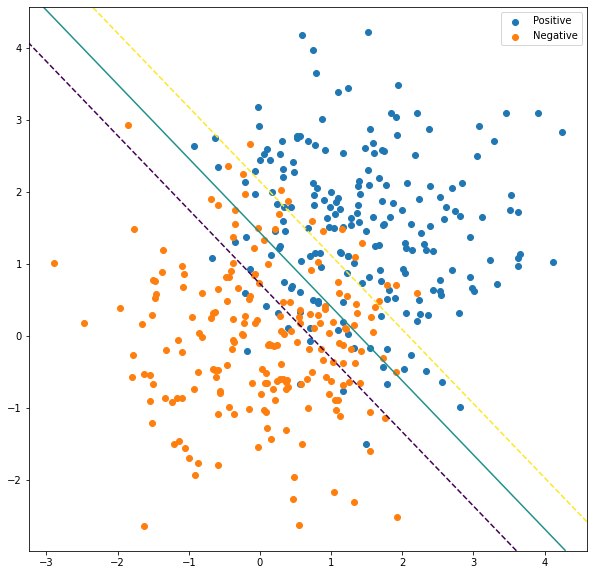

In [66]:
data = pd.read_csv("SVM-Q2.csv")

# Prepare Data
data_arr = data.values
lambda_value = 1
n = len(data_arr)
data_arr = np.hstack([np.ones(n).reshape(-1,1), data_arr])
X = data_arr[:, :3]
y = data_arr[:, 3]
init = np.zeros(3)

# Optimize
def gradient(b,X,y,lambda_value):
    grad = np.zeros(3)
    for i in range(len(X)):
        grad = grad - y[i]*X[i]*(1-1/(1+np.exp(-y[i]*b @ X[i].T)))
    grad = grad + 2*lambda_value*b
    return grad


def loss_calc(b,X,y,lambda_):
    loss_iter = 0
    for i in range(len(X)):
        loss_iter += np.log(1+np.exp(-y[i]*(b @ X[i].T)))
    return loss_iter+lambda_*np.linalg.norm(b)**2


# Run the optimization algorithm
solve = minimize(loss_calc,
                 init,
                 args=(X,y,lambda_value),
                 method='BFGS',
                 jac=gradient)


betas = solve.x
loss = solve.fun
print("Optimized Parameters:")
print("b0: {}, b1: {}, b2: {}".format(*betas))
print('Total Loss: {}'.format(loss))

decision_function = lambda x: betas[0] + betas[1]*x[0] + betas[2]*x[1]

def pred(data):
    data = data[:, 1:3]
    decisions = []
    pred = []
    for dat in data:
        dec = decision_function(dat)
        decisions.append(dec)
        if dec >= 0:
            pred.append(1)
        else:
            pred.append(-1)
    return decisions, pred

decisions, pred = pred(data_arr)

print("Misclassification Error:", round(1-accuracy_score(pred, y), 3))

decision_out = decisions
float_tol = 1e-1
plt.figure(figsize=(10,10))
plt.scatter(x='x1',y='x2',data=data.loc[data['y']==1],label='Positive')
plt.scatter(x='x1',y='x2',data=data.loc[data['y']==-1],label='Negative')
plt.legend()

xlim = plt.xlim()
ylim = plt.ylim()

# create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
y = np.linspace(ylim[0], ylim[1], 30)
Y, X = np.meshgrid(y, x)
XY = np.vstack([X.flatten(), Y.flatten()])
P = decision_function(XY).reshape(X.shape)

plt.contour(X, Y, P, levels=[-1,0,1],linestyles=['--','-','--'])

plt.show()